In [35]:
import os

import tifffile
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from einops import rearrange

In [36]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
%autoreload 2

In [38]:
from dino_extended.data.utils import listfiles
from dino_extended.data.multiplex import TileTransform

In [39]:
fps = sorted(listfiles('/data/spatial_transcriptomics/highres_images/breast', regex=r'HT206B1.*.tif'))
fps

['/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U2.tif',
 '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U3.tif',
 '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U4.tif',
 '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U5.tif']

In [40]:
def preprocess_he(img, scale=None):
    if isinstance(img, str):
        img = tifffile.imread(img)

    img = torch.tensor(img, dtype=torch.float32)
    img = rearrange(img, 'h w c -> c h w')
    
    img -= img.min()
    img /= img.max()
    
    if scale is not None:
        size = int(img.shape[-2] * scale), int(img.shape[-1] * scale)
        img = TF.resize(img, size)
    
    return img

In [105]:
8 % 5

3

In [107]:
class TileDataset(Dataset):
    """Registration Dataset"""
    def __init__(self, hes, size=(256, 256), scale=None, transform=None, length=1028):
        self.length = length
        self.hes = [preprocess_he(he, scale=scale) for he in hes]

        self.transform = transform if transform is not None else TileTransform(size=size)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        i = (idx + 1) % len(self.hes)
        return self.transform(self.hes[i])

In [108]:
ds = TileDataset(fps, size=(256, 256), scale=.5)

In [78]:
tile = ds[0]
tile.shape

torch.Size([3, 256, 256])

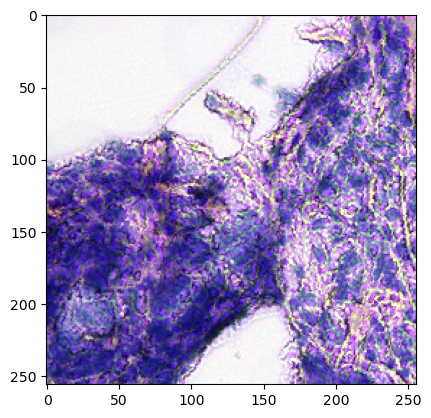

In [79]:
plt.imshow(rearrange(tile.numpy(), 'c h w -> h w c'))

In [111]:
dl = DataLoader(ds, batch_size=128, shuffle=True, num_workers=20)

In [112]:
b = next(iter(dl))
b.shape

torch.Size([128, 3, 256, 256])